In [17]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer, MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("Clinical data/clinical_data.csv", index_col=0)

# Separate categorical and numerical
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(exclude=['object']).columns

# Impute missing values
df[cat_cols] = SimpleImputer(strategy="most_frequent").fit_transform(df[cat_cols])
df[num_cols] = SimpleImputer(strategy="mean").fit_transform(df[num_cols])

for col in cat_cols:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

# Combine and scale
scaler = MaxAbsScaler()

scaled = df.copy()
scaled[num_cols] = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols, index=df.index)
scaled

,histology_diagnosis,age,sex,race,participant_country,tumor_site,tumor_size_cm,tumor_necrosis,lymph_vascular_invasion,perineural_invasion,pathologic_staging_regiol_lymph_nodes_pn,pathologic_staging_primary_tumor_pt,pathologic_staging_distant_metastasis_pm,clinical_staging_distant_metastasis_cm,residual_tumor,tumor_stage_pathological,additiol_pathologic_findings,bmi,alcohol_consumption,tobacco_smoking_history,follow_up_days,vital_status,is_this_patient_lost_to_follow_up,cause_of_death
case_id,,,,,,,,,,,,,,,,,,,,,,,,
C3L-00017,1,0.811765,1,1,11,2,0.600000,0,1,2,0,3,2,2,3,2,10,0.618809,0,0,0.312317,1,1,7
C3L-00102,1,0.494118,1,1,11,2,0.400000,0,2,2,2,2,2,0,0,4,2,0.587606,1,4,0.182551,0,0,7
C3L-00189,1,0.800000,0,1,1,2,0.360000,0,1,2,1,2,0,0,1,3,20,0.747982,0,1,0.758798,0,0,7
C3L-00277,1,0.811765,1,1,6,4,0.666667,0,1,2,1,3,2,2,2,3,6,0.523674,0,4,0.447214,0,1,7
C3L-00401,1,0.729412,0,1,1,0,0.373333,0,2,2,1,2,0,0,0,3,1,0.489199,0,4,0.900293,1,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C3N-04119,1,0.635294,1,1,2,4,0.400000,0,1,2,1,2,2,2,0,3,2,0.516256,4,4,0.223607,0,0,7
C3N-04126,1,0.494118,1,1,2,2,0.466667,0,2,2,2,2,0,2,0,4,2,0.531966,4,4,0.255132,0,0,7
C3N-04282,1,0.882353,1,1,7,2,0.533333,1,2,2,1,2,1,2,1,5,20,0.349116,0,3,0.222141,0,0,7


In [18]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering

scores = []
for k in range(2, 10):
    spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors',
                                  assign_labels='kmeans', random_state=42)
    spectral_labels = spectral.fit_predict(scaled)
    score = silhouette_score(scaled, spectral_labels)
    scores.append((k, score))

print(scores)

[(2, 0.13776885544053386), (3, 0.3571712652143481), (4, 0.31091865644366223), (5, 0.25470526537516863), (6, 0.27254210615858654), (7, 0.22607118281339542), (8, 0.228958816686424), (9, 0.22519973813489516)]


In [19]:
from sklearn.cluster import SpectralClustering, KMeans

n_clusters = 3

spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=0)
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

spectral_labels = spectral.fit_predict(scaled)
kmeans_labels = kmeans.fit_predict(scaled)

In [20]:
scaled['cluster'] = spectral_labels
summary = scaled.groupby('cluster').agg(['mean', 'std', 'count'])
summary

histology_diagnosis                  ... cause_of_death                
                       mean       std count  ...           mean       std count
cluster                                      ...                               
0                  0.971831  0.166633    71  ...       6.647887  1.484189    71
1                  0.968750  0.176777    32  ...       6.687500  1.533234    32
2                  0.945946  0.229243    37  ...       7.216216  0.583816    37

[3 rows x 72 columns]

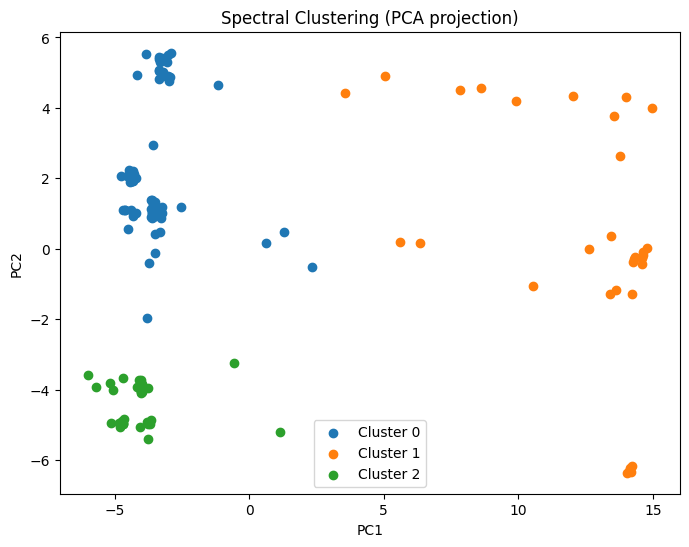

In [21]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled.drop(columns=['cluster']))

plt.figure(figsize=(8,6))
for i in range(n_clusters):
    plt.scatter(reduced[spectral_labels==i,0], reduced[spectral_labels==i,1], label=f"Cluster {i}")
plt.legend()
plt.title("Spectral Clustering (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig(r'images/spectral_PCA.png', transparent=True, bbox_inches='tight')

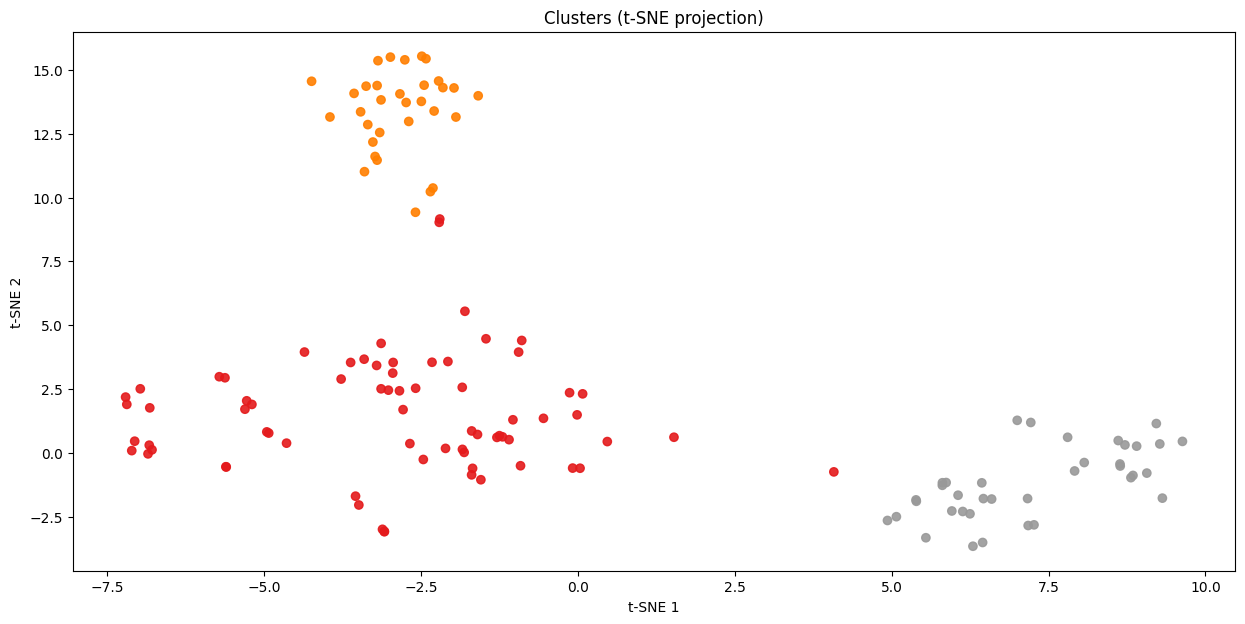

In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(scaled.drop(columns=['cluster'])) 

plt.figure(figsize=(15,7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=spectral_labels, cmap='Set1', alpha=0.9)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Clusters (t-SNE projection)')

plt.savefig(r'images/spectral_tSNE.png', transparent=True, bbox_inches='tight')

In [23]:
scaled['cluster'] = kmeans_labels
summary = scaled.groupby('cluster').agg(['mean', 'std', 'count'])
summary

histology_diagnosis                  ... cause_of_death                
                       mean       std count  ...           mean       std count
cluster                                      ...                               
0                  0.947368  0.226294    38  ...       7.236842  0.589742    38
1                  0.972222  0.165489    72  ...       6.638889  1.466101    72
2                  0.966667  0.182574    30  ...       6.666667  1.582955    30

[3 rows x 72 columns]

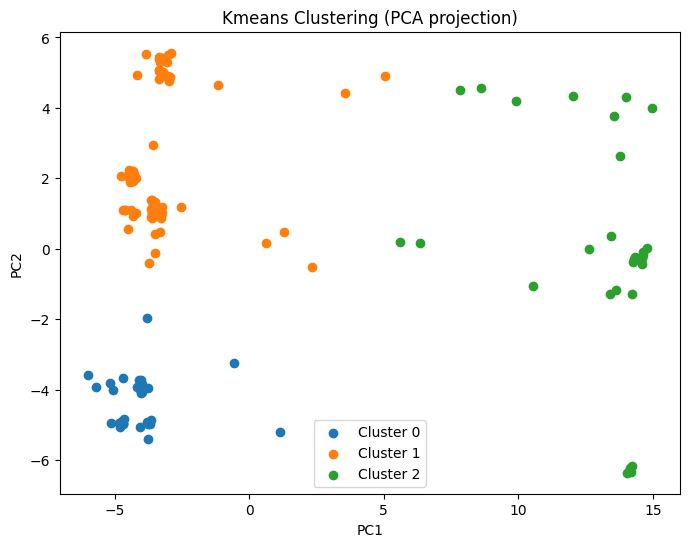

In [24]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled.drop(columns=['cluster']))

plt.figure(figsize=(8,6))
for i in range(n_clusters):
    plt.scatter(reduced[kmeans_labels==i,0], reduced[kmeans_labels==i,1], label=f"Cluster {i}")
plt.legend()
plt.title("Kmeans Clustering (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig(r'images/Kmeans_PCA.png', transparent=True, bbox_inches='tight')

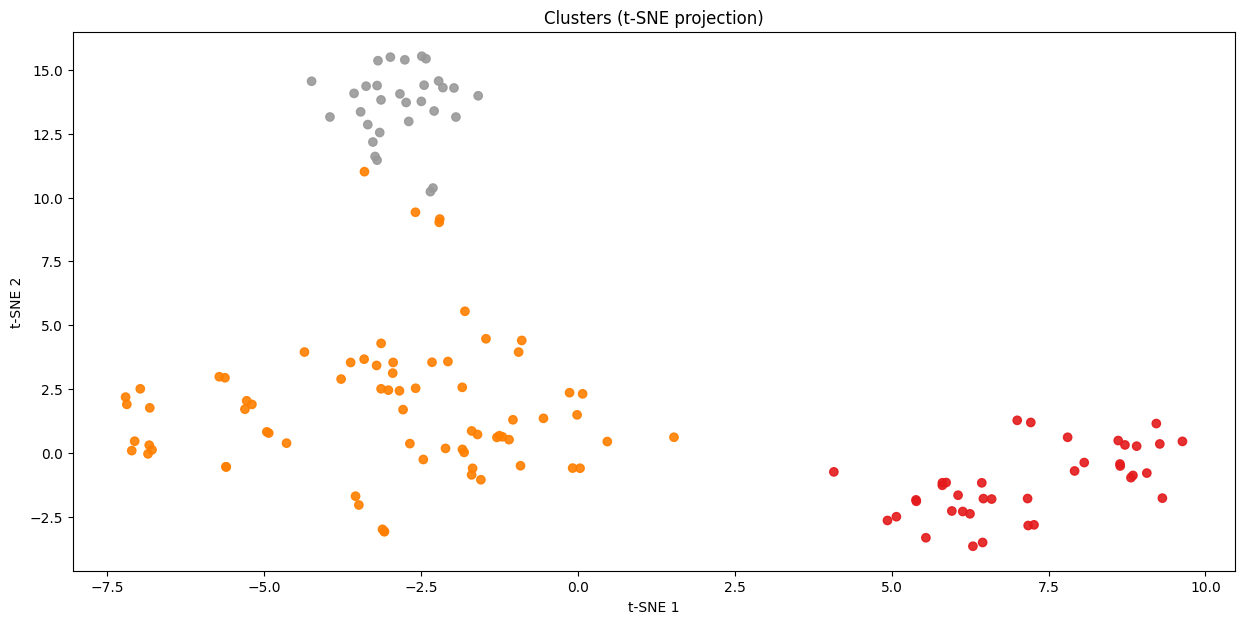

In [25]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(scaled.drop(columns=['cluster'])) 

plt.figure(figsize=(15,7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='Set1', alpha=0.9)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Clusters (t-SNE projection)')

plt.savefig(r'images/Kmeans_tSNE.png', transparent=True, bbox_inches='tight')